In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Input, BatchNormalization, Dropout
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
from sklearn.metrics import confusion_matrix

### Importation de la base de données MNIST (ce sont des images de chiffres manuscrits, hello world du deep learning)

In [3]:
from keras.datasets import cifar10
(cx_train, cy_train), (cx_test, cy_test) = cifar10.load_data()

In [4]:
print(cx_train.shape)
cx_train[0].shape

(50000, 32, 32, 3)


(32, 32, 3)

### Affichage exemple

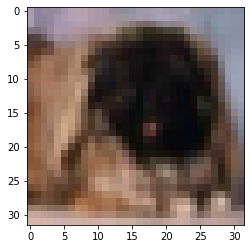

In [5]:
r = np.random.randint(cx_train.shape[0])
plt.imshow(cx_train[r]) #,cmap = "hot")

### Normalisation des données

In [7]:
#verifing max value in tab for normalisation
print(cx_train.max(), cx_test.max())

255 255


In [8]:
cx_train = cx_train/255
cx_test = cx_test/255

###  Passage des données (0,1,2,3...) en catégories. Exemple : 3 devient (0,0,0,1,0,0,0,0,0,0)

In [9]:
cy_train_cat = to_categorical(cy_train,num_classes = 10)
cy_test_cat = to_categorical(cy_test,num_classes = 10)

### Construction du réseau

In [11]:
model = Sequential()

#INPUT layer
model.add(Flatten(input_shape = (32,32,3))) #Passage de tableau 3D(3tab -> X*Y*color) à 1D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
cx_train[r].flatten().shape #visualization of flatten shape

(3072,)

In [12]:
#https://keras.io/api/layers/initializers/
#https://keras.io/api/layers/regularizers/   

# LAYER 1
model.add(Dense(256,activation = "relu", kernel_initializer = "he_normal",kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
# LAYER 2
model.add(Dense(128,activation = "relu", kernel_initializer = "he_normal",kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
# LAYER 3
model.add(Dense(64,activation = "relu", kernel_initializer = "he_normal",kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
# OUTPUT LAYER
model.add(Dense(10,activation = "softmax", kernel_initializer = "he_normal",kernel_regularizer = regularizers.l2(0.01)))

### Optimizer et loss function

In [13]:
# gradient descet tool and increment
opt = optimizers.SGD(lr = 0.01)

In [14]:
# Choice of model loss function, and metrics to add to training histoty
model.compile(loss = "binary_crossentropy",optimizer = opt, metrics = ['categorical_accuracy'])

### Affichage de l'architecture du réseau 

In [15]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)              

### Mise en place du Early Stopping

In [16]:
early_stopping = EarlyStopping(monitor = "val_loss",patience = 10,restore_best_weights=True)
# stop if no improvement of training

### Checkpointer pour sauvegarder le meilleur modèle

In [17]:
checkpointer = ModelCheckpoint(filepath = "model_exemple_cyphar_best.h5",verbose = 1,save_best_only = True)

### Apprentissage

In [18]:
batch_size = 256
epochs=20
hist = model.fit(cx_train,cy_train_cat,epochs = epochs,
                 batch_size = batch_size,
                 callbacks = [early_stopping,checkpointer],
                 validation_data=(cx_test, cy_test_cat))
# possible to use : validation_split = 0.1 , if no test set defined

Epoch 1/20
194/196 [============================>.] - ETA: 0s - loss: 9.1136 - categorical_accuracy: 0.1579
Epoch 00001: val_loss improved from inf to 8.72010, saving model to model_exemple_cyphar_best.h5
196/196 [==============================] - 3s 15ms/step - loss: 9.1112 - categorical_accuracy: 0.1582 - val_loss: 8.7201 - val_categorical_accuracy: 0.1935
Epoch 2/20
192/196 [============================>.] - ETA: 0s - loss: 8.4182 - categorical_accuracy: 0.2148
Epoch 00002: val_loss improved from 8.72010 to 8.06410, saving model to model_exemple_cyphar_best.h5
196/196 [==============================] - 3s 14ms/step - loss: 8.4128 - categorical_accuracy: 0.2150 - val_loss: 8.0641 - val_categorical_accuracy: 0.2662
Epoch 3/20
192/196 [============================>.] - ETA: 0s - loss: 7.7898 - categorical_accuracy: 0.2470
Epoch 00003: val_loss improved from 8.06410 to 7.46328, saving model to model_exemple_cyphar_best.h5
196/196 [==============================] - 3s 14ms/step - loss: 7

 ### Affichage de l'historique de l'apprentissage

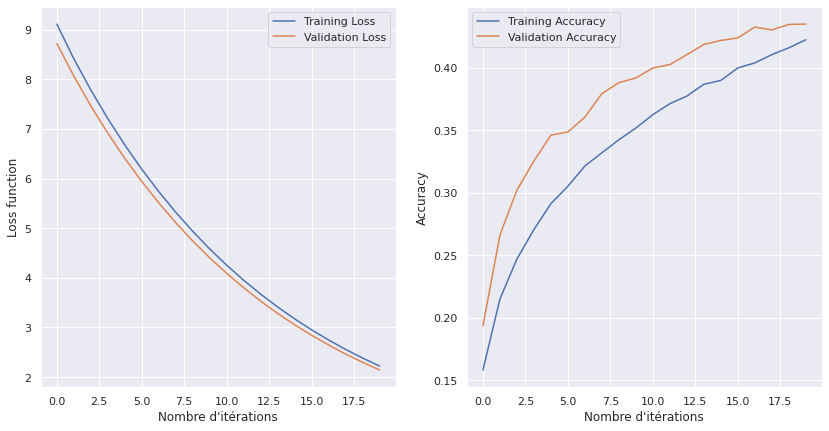

In [22]:
figure = plt.figure(figsize=(14,7))


ax1 = plt.subplot(121)
ax1.plot(hist.history["loss"],label = "Training Loss")
ax1.plot(hist.history["val_loss"],label = "Validation Loss")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Loss function")
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(hist.history["categorical_accuracy"],label = "Training Accuracy")
ax2.plot(hist.history["val_categorical_accuracy"],label = "Validation Accuracy")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Accuracy")
plt.legend()

Test loss: 2.1436922550201416
Test accuracy: 0.4350000023841858
[3 8 8 ... 5 1 7]
[3 9 8 ... 3 6 7]


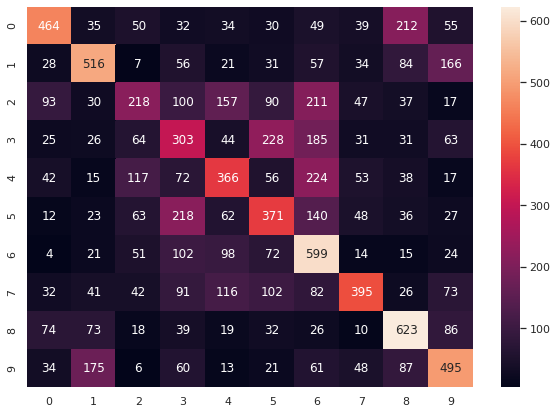

In [35]:
# PLOTTING HEATMAP OF ACCURACY
score_mpl = model.evaluate(cx_test, cy_test_cat, verbose=0)
predict_mpl = model.predict(cx_test)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])


# step1 invert categorical in order to use heat map
cy_test_inv = np.argmax(cy_test_cat, axis=-1)
print(cy_test_inv)
predict_tab = predict_mpl.argmax(1)
print(predict_tab)

fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax = sn.heatmap(pd.DataFrame(confusion_matrix(cy_test_inv, predict_tab)), annot=True, fmt="d")

 ### Accuracy sur la base de test
 -Accuracy on test set: 42.95 % avec 128/layer 10 iter
 -Accuracy on test set: 46.26 % avec 256/layer 15 iter
 -Accuracy on test set: 46.94 % avec 128/layer 10 iter

In [138]:
cy_testflat = np.ndarray.flatten(cy_test)

In [139]:
prediction_bar = model.predict(cx_test)
prediction = np.argmax(prediction_bar,axis = 1)

print("Accuracy on test set: " + str(np.round(np.sum(prediction == cy_testflat)/cx_test.shape[0]*100,3)) + " %")

Accuracy on test set: 44.56 %


In [104]:
prediction

array([3, 9, 8, ..., 3, 6, 7])

### Essai sur la base de test

No handles with labels found to put in legend.
No handles with labels found to put in legend.


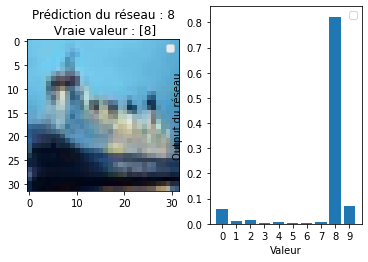

In [99]:
figure = plt.figure()

figure.clear()

r = np.random.randint(cx_test.shape[0])

ax1 = plt.subplot(121)
ax1.imshow(cx_test[r],cmap = "hot")
plt.title("Prédiction du réseau : " + str(prediction[r]) + "\n Vraie valeur : " + str(cy_test[r]))
plt.legend()

ax2 = plt.subplot(122)
ax2.bar(np.arange(10),height = prediction_bar[r],tick_label = np.arange(10))
plt.xlabel("Valeur")
plt.ylabel("Output du réseau")
plt.legend()

 ### Exemple d'erreur

No handles with labels found to put in legend.
No handles with labels found to put in legend.


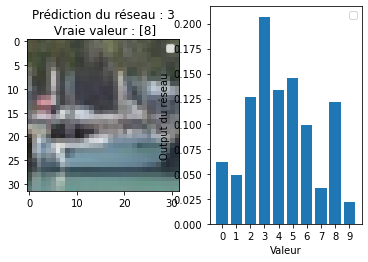

In [101]:
figure = plt.figure()

figure.clear()

erreurs = np.where(prediction != cy_test)[0]

r2 = np.random.randint(erreurs.shape[0])
e = erreurs[r2]

ax1 = plt.subplot(121)
ax1.imshow(cx_test[e],cmap = "hot")
plt.title("Prédiction du réseau : " + str(prediction[e]) + "\n Vraie valeur : " + str(cy_test[e]))
plt.legend()

ax2 = plt.subplot(122)
ax2.bar(np.arange(10),height = prediction_bar[e],tick_label = np.arange(10))
plt.xlabel("Valeur")
plt.ylabel("Output du réseau")
plt.legend()